## Objectives:

1. To understand the major causes of Understocking and OverStocking at Big Pharma
2. Forecast the quantity of products the company should purchase for their warehouse in the coming month

### Required Libraries

In [1]:
import pandas as pd # data manipulation
import numpy as np # numerical python
import warnings # avoid warnings
import matplotlib.pyplot as plt #data visualization
import seaborn as sns #data visualization
%matplotlib inline
# !pip install tqdm
from tqdm import tqdm #visualize iterations


from scipy.stats import norm, skew #for some statistics
from scipy import stats #qqplot
import statsmodels.api as sm #for decomposing the trends, seasonality etc.


# import data utilities required for performing various operations of analysis
from utils import *

### Reading the dataset


In [2]:
path = "/home/rohi/Desktop/Kazi/GetInnotized/pharmaceutical-sales-demand.xlsx"
# read the dataset
data = read_df(path) # takes quite some time due to a for loop (1minute 40 seconds)


pharmaceutical-sales-demand
shape of data : (1048575, 3)


,Columns name,Type,Count unique values,Count Nan values,Ratio Nan values,Unique values,Max,Min,Mean
0,Date,datetime64[ns],304,0,0.0000,"[2020-10-05T00:00:00.000000000, 2020-10-19T00:...",0,0,0.0000
1,Product ID,object,7798,0,0.0000,"[I6DO4, O40SR, Y03MS, B0OR2, EIM03, 3ML0O, LO5...",0,0,0.0000
2,Stock Demand,int64,5704,0,0.0000,"[-1, 16, 306, 307, 6, 22, 3, 1, 0, 28, 11, 20,...",149004,-12226,79.7059


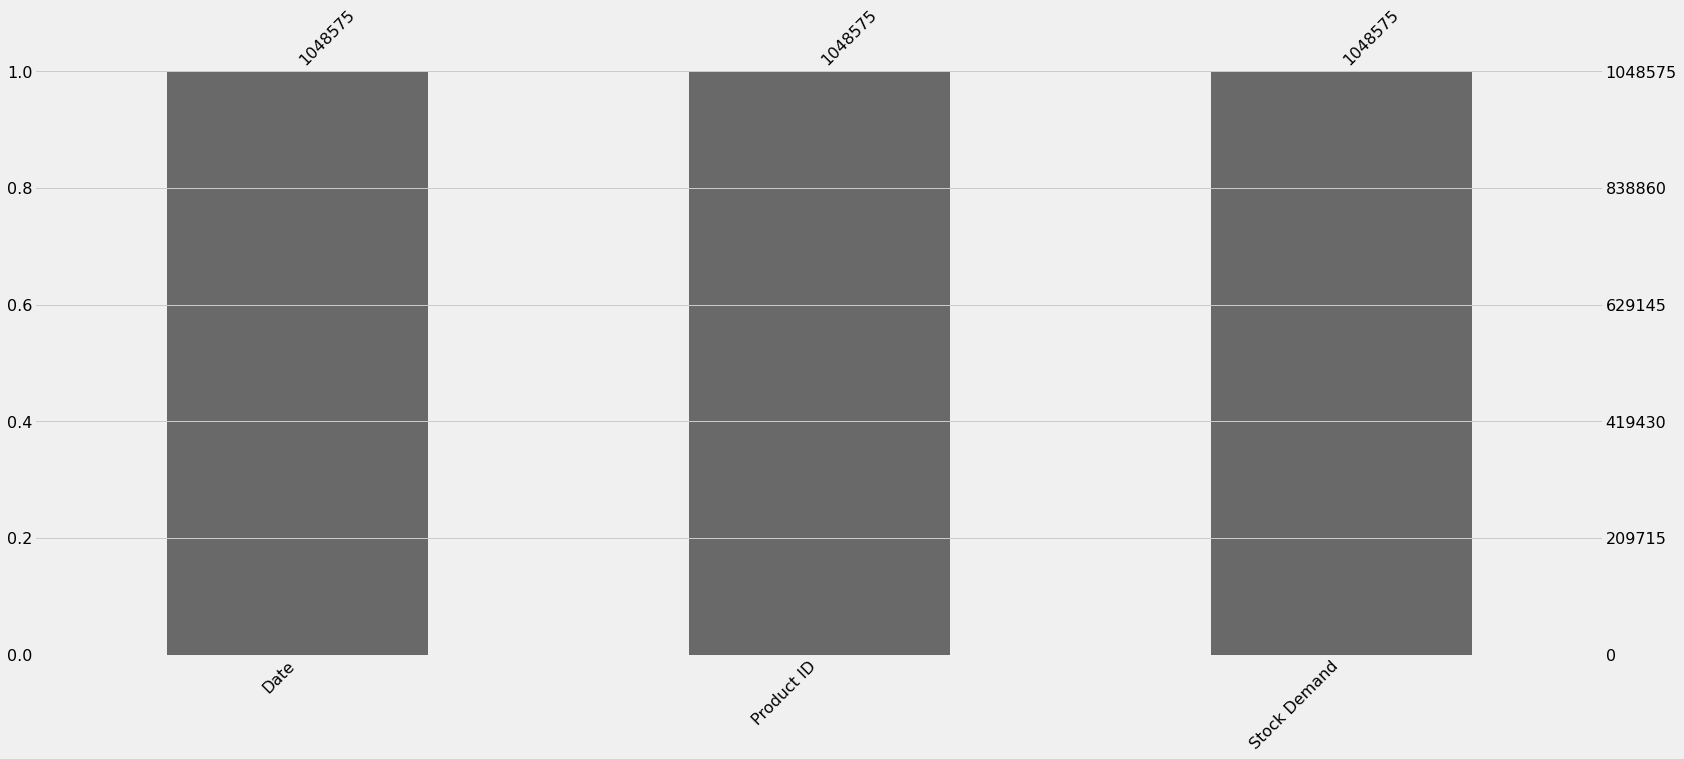

In [3]:
#visualize missing values in the data
visualize_missingness(data);

### Data Cleaning Strategies

- Clearly, the data has no null values
- Maximum stock demanded was 149004 while minimum is a negative. 
- Clearly, we do not expect that the stock would be less than 0
- It's possible to make the column names to snake_case for easy usage
- Check for duplicates in the data

##### 1. Clean the column names

In [4]:
data.columns = clean_cols(data)
data.columns

Index(['date', 'product_id', 'stock_demand'], dtype='object')

##### 2. Remove duplicate values

In [5]:
data = drop_dups(data)
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1039659 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   date          1039659 non-null  datetime64[ns]
 1   product_id    1039659 non-null  object        
 2   stock_demand  1039659 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 31.7+ MB


#### 3. Remove -ve stock values from the data

In [6]:
data = clean_negatives(data)

#### 4. Remove the outliers that may exist in the Stock Demand column

In [7]:
low, high = detect_outliers(data['stock_demand'])
mask =   ((data['stock_demand'] > high) | (data['stock_demand'] < low))
tot_no_of_outlier = mask.sum()
outlier_proportion = tot_no_of_outlier/len(data['stock_demand'])
print(f'Proportion of outliers in dataset {round(outlier_proportion * 100,2)}%')
data = data[~mask]

Proportion of outliers in dataset 14.38%


#### 5. Remove Date in the product_id column

In [8]:
data.groupby('product_id').sum()

,stock_demand
product_id,
1970-04-01 00:00:00,4
2022-03-23 00:00:00,141
2022-03-30 00:00:00,721
0010R,31
001NT,108
...,...
ZR0D5,784
ZR20A,2082
ZRD36,2046


In [9]:
# Convert data time product values to null
import datetime
data['product_id'] = data["product_id"].apply(lambda x: np.nan if isinstance(x,datetime.datetime) else x)
#removing missing values from the dataset
data.dropna(inplace=True)

### Exploratory Data Analysis

#### 0. GroupBy the daily product data so as to have the total stock demand as a sum of all the products sold on a particular day. 

In [10]:
df = data.groupby('date').sum()

#### 1. Let's check the distribution of our target value: stock_demand

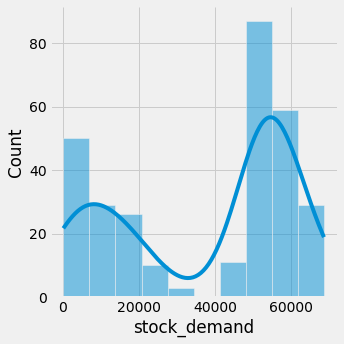

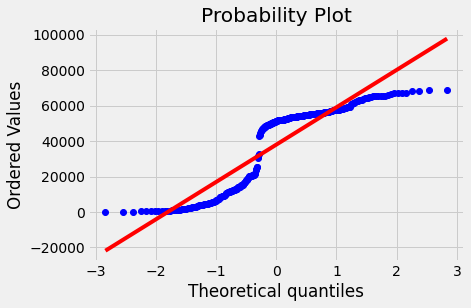

In [11]:
sns.displot(df['stock_demand'], kde=True)
## QQ-Plot
fig = plt.figure()
residuals = stats.probplot(df['stock_demand'], plot=plt)

#### 2. Time Series plot for the whole data

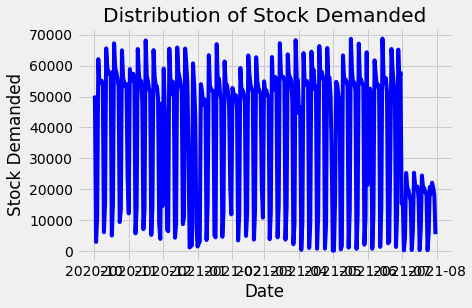

In [13]:
# Visualise the data
def PlotTimeSeries(x, y, xlabel, ylabel, title):
    plt.plot(x, y, color = 'blue')
    plt.gca().set(title = title, xlabel = xlabel, ylabel = ylabel)
    plt.show()
    
PlotTimeSeries(df.index, df.stock_demand, 'Date', 'Stock Demanded', 'Distribution of Stock Demanded')

To clearly represent the features, let's break it down to specific date features

#### 3. Create date features

In [14]:
df['date'] = df.index
df['year'] = df.date.apply(lambda x: x.isocalendar()[0])
df['month_num'] = df.date.dt.month
df['month'] = df.date.dt.strftime('%b')
df['week'] = df.date.apply(lambda x: x.isocalendar()[1])
df.head()

,stock_demand,date,year,month_num,month,week
date,,,,,,
2020-10-01,49514,2020-10-01,2020,10,Oct,40
2020-10-02,49760,2020-10-02,2020,10,Oct,40
2020-10-03,2954,2020-10-03,2020,10,Oct,40
2020-10-04,10812,2020-10-04,2020,10,Oct,40
2020-10-05,62103,2020-10-05,2020,10,Oct,41


#### 3.1 Confirm the Presence of Outliers

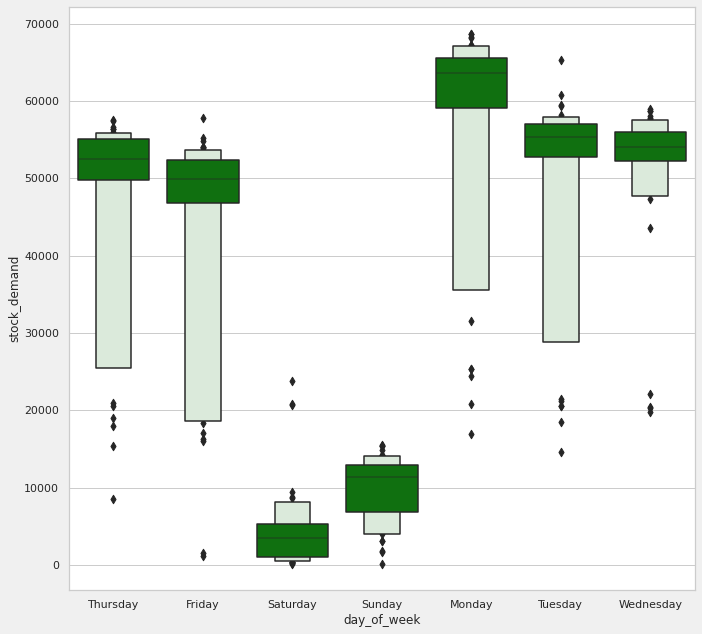

In [15]:
df['day_of_week'] = df['date'].dt.day_name()
plt.figure(figsize=(10,10))
sns.set(style="whitegrid")
sns.boxenplot(y="stock_demand", x="day_of_week",data=df, scale="linear",color="Green");

High product demands are witnessed on Monday through wednesday. However, on Sartuday and Sunday, the product demands are lower.

#### 4. Try to visualize the sales of different months

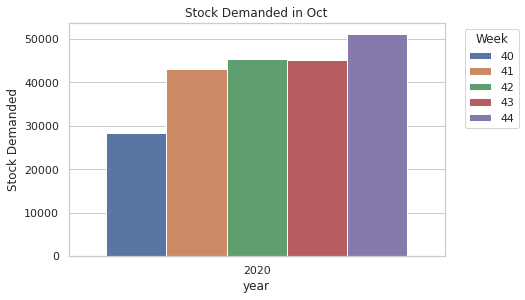

In [16]:
def StockatMonthSummary(month = "Oct"):
    monthly_demand = df[df.month == month]
    monthly_summary = monthly_demand.groupby(by = ['year','week'])['stock_demand'].mean(numeric_only = True).reset_index()
    
    ax = sns.barplot(x = 'year', y = 'stock_demand', data = monthly_summary, hue = 'week')
    ax.set_title(f"Stock Demanded in {month}")
    ax.set_ylabel('Stock Demanded')
    plt.legend(bbox_to_anchor=(1.04,1), loc = 'upper left', title = 'Week')
    plt.show()

StockatMonthSummary()

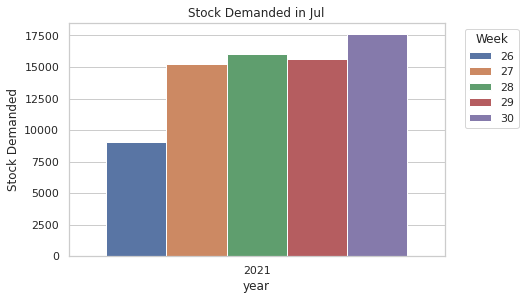

In [17]:
StockatMonthSummary('Jul')

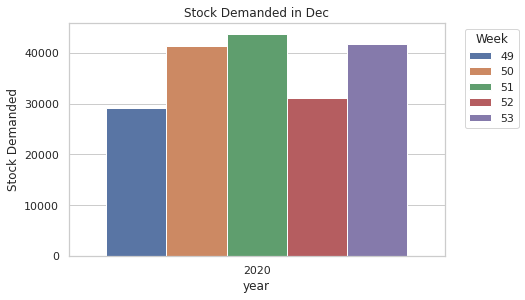

In [18]:
StockatMonthSummary('Dec')

Clearly, at the start of each month, there is less purchase of the product, where as there is higher quantities of the products purchaded during the end of of the month. 

#### 5. Visualize the timeseries for the monthly scenarios

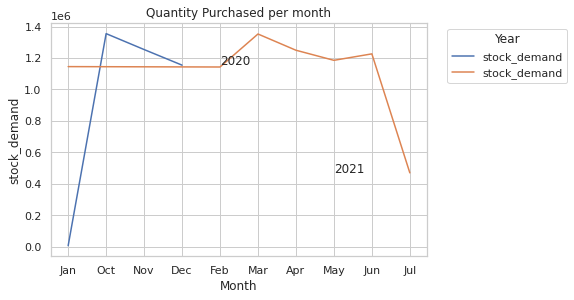

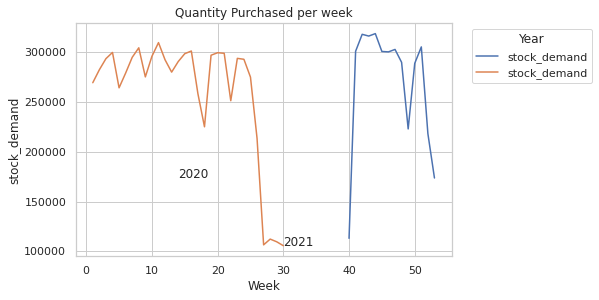

In [19]:
def PlotMonthlySeries(data, timeframe):
    years = pd.unique(data.year).tolist()
    
    for i,year in enumerate(years):
        # Only use data from given year
        subset = data[data['year'] == year]
        if timeframe == 'month':
            # If month then sum up stock_demand for the whole month to plot a smoother graph
            groupby_cols, sort_col = ['month','month_num'], 'month_num'
            subset = subset.groupby(by = groupby_cols)['stock_demand'].sum().reset_index().sort_values(sort_col)
        else:
            groupby_cols, sort_col = 'week', 'week'
            subset = subset.groupby(by = groupby_cols)['stock_demand'].sum().reset_index()
            
        # Plot month and value for given year
        plt.plot(timeframe, 'stock_demand', data = subset)
        # Add year as text at the last data point (Dec)
        plt.text(x = subset.shape[0], y = subset['stock_demand'].values[-1], s = year)
        plt.legend(bbox_to_anchor=(1.04,1), loc = 'upper left', title = 'Year')
    
    plt.gca().set(xlabel = timeframe.capitalize(), ylabel = 'stock_demand', title = f'Quantity Purchased per {timeframe}')
    plt.show()
    
PlotMonthlySeries(df,'month')
PlotMonthlySeries(df,'week')

#### 6. TimeSeries Decomposition

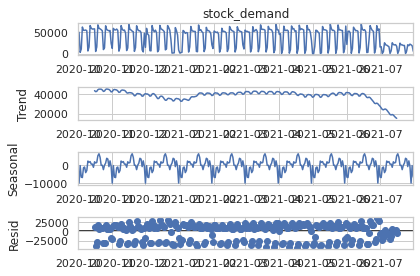

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df.stock_demand, model='aditive', period=30)
decomposition.plot();

#### 7. Test for stationarity

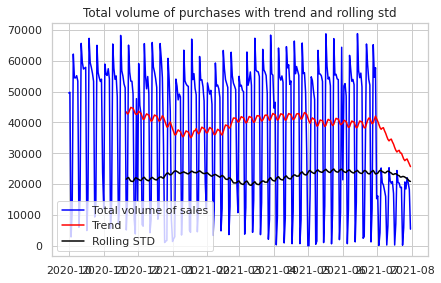

In [21]:
from statsmodels.tsa.stattools import adfuller

def PlotStationarity(data):
    
    # Visualisation of product demand, trend, and standard deviation
    data['rolling_mean'] = data['stock_demand'].rolling(window = 52).mean()
    data['rolling_std'] = data['stock_demand'].rolling(window = 52).std()
    
    plt.plot(data.date, data.stock_demand, color = 'Blue', label = 'Total volume of sales')
    plt.plot(data.date,data.rolling_mean, color = 'Red', label = 'Trend')
    plt.plot(data.date,data.rolling_std, color = 'Black', label = 'Rolling STD')
    
    plt.legend(loc = 'best')
    plt.title('Total volume of purchases with trend and rolling std')
    plt.show()
    
  
PlotStationarity(df)

In [22]:
def TestForStationarity(data):
    # Apply DF test where null hypothesis is that the time series is non stationary
    dftest = adfuller(df['stock_demand'])
        
    df_df = pd.Series(dftest[:4], index = ['Test Statistic','P-value','Lags','Observations'])
    for k, v in dftest[4].items():
        df_df[f'Critical Value ({k})'] = v

    print(df_df)

TestForStationarity(df)

Test Statistic          -1.4585
P-value                  0.5540
Lags                    16.0000
Observations           287.0000
Critical Value (1%)     -3.4533
Critical Value (5%)     -2.8717
Critical Value (10%)    -2.5722
dtype: float64


## Model Building

In [25]:
## Hyper-Parameters for the SARIMAX model
p = range(0,2)
d = 1
q = range(0,2)

P = range(0,2)
D = 0
Q = 1
S = 52

from itertools import product

# Create a list of all combinations of hyperparameters to be used
all_parameters = list(product(p, q, P))

print('Number of models we will build: %s' %len(all_parameters))


Number of models we will build: 8


In [26]:
from statsmodels.tsa.statespace import sarimax
import numpy as np
from sklearn import metrics

#### Define the Metric for Evaluation as the Mean Absolulte Percentage Error (MAPE) and Mean Squared Error(MSE)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        
        return np.mean(np.abs(1 - y_pred/y_true))

#### Model Building

In [27]:
def BuildSarimaModels(all_parameters, Q = 1, d = 1, D = 0, S = 52):
    
    results_to_store = []
    actual = data.stock_demand[S+d:].values
        
    for parameters in all_parameters:
        
        p, q, P = parameters
        
        # Some parameter combinations will fail to converge and these need to be ignored
        try:
            model = sarimax.SARIMAX(data.stock_demand, order = (p,d,q), seasonal_order = (P,D,Q,S))
            results = model.fit(disp = 0)
        
        except:
            continue
        
        if results.mle_retvals['converged']:
            
            aic = results.aic

            predicted = results.fittedvalues[S+d:].values

            mae = metrics.mean_absolute_error(actual, predicted)
            mse = metrics.mean_squared_error(actual, predicted)    
            mape = mean_absolute_percentage_error(actual, predicted)  

            results_to_store.append([parameters, aic, mae, mse, mape])

    results_table = pd.DataFrame(results_to_store, columns = ['Parameters','AIC','MAE','MSE','MAPE'])
    
    return results_table

sarimax_models = BuildSarimaModels(all_parameters)
sarimax_models = sarimax_models.sort_values(by = 'AIC', ascending = True)

In [ ]:
sarimax_models